#PSBe com os valores de RNO obtidos pela diferença entre o LAIR e o EBIT

PSBe = ((Patrimônio Líquido + Receita Líquida12m + Resultado ñ operacional12m + (Lucro12m - Resultado ñ operacional12m) * ABS(Margem Líquida) ^ (-k * ABS(Margem Líquida))) * Cotação unitária) / nº de ações



In [ ]:
import pandas as pd
import numpy as np
import requests
import scipy
from scipy import optimize
import matplotlib.pyplot as plt

,tkr,PL,RL,RNO,LL,ML,Nº Acoes,Valor de Mercado,Cotacao,tkr_n
0,CTSA3,2.854610e+08,4.502560e+08,-25293000.0,-16000.0,-0.000036,111299000.0,2.604400e+08,2.34,CTSA
4,OMGE3,3.722190e+09,1.039580e+09,-364704000.0,-2223000.0,-0.002138,196036000.0,8.321730e+09,42.45,OMGE
5,LINX3,1.684040e+09,8.647570e+08,-22520000.0,-4762000.0,-0.005507,189409000.0,7.381270e+09,38.97,LINX
6,PLDN4,2.899390e+08,3.412290e+08,0.0,-567000.0,-0.001662,645253000.0,3.135930e+08,486.00,PLDN
7,DASA3,3.896020e+09,5.886730e+09,-365305000.0,-190678000.0,-0.032391,480814000.0,7.837270e+10,163.00,DASA
...,...,...,...,...,...,...,...,...,...,...
786,MOVI3,2.217260e+09,4.201100e+09,-168788000.0,9585000.0,0.002282,298921000.0,5.643630e+09,18.88,MOVI
788,SQIA3,4.335560e+08,1.990290e+08,379000.0,2067000.0,0.010385,70549000.0,1.580300e+09,22.40,SQIA
789,LWSA3,6.570610e+08,4.532350e+08,-16589000.0,17720000.0,0.039097,585462000.0,1.706040e+10,29.14,LWSA
793,APER3,1.790790e+08,1.007520e+08,-78000.0,102000.0,0.001012,11480000.0,6.225600e+08,54.23,APER


Optimization terminated successfully.
         Current function value: -0.769304
         Iterations: 13
         Function evaluations: 26
O valor para máxima correlação encontrada foi de  6.819091796875


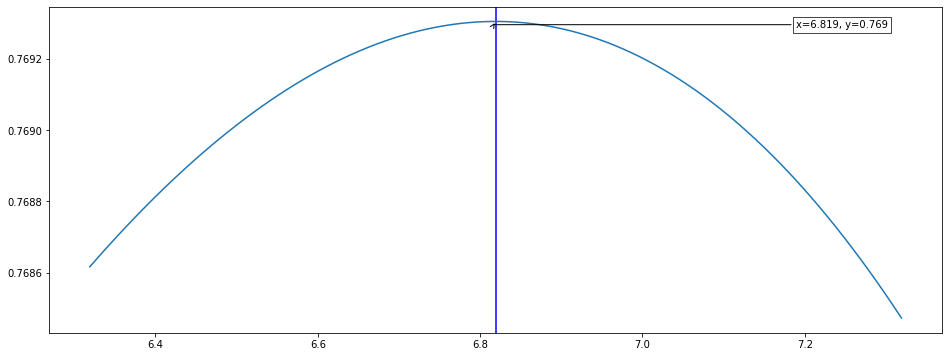

In [ ]:
urlf0 = 'https://www.fundamentus.com.br/resultado.php'
header = {
  "User-Agent": "Chrome/50.0.2661.75",
  "X-Requested-With": "XMLHttpRequest"
}
rf0 = requests.get(urlf0, headers=header)

dff0 = pd.read_html(rf0.text, decimal=',', thousands='.')[0]

dff0=dff0[~(dff0['P/L']==0.00)] #Retirando ações com P/L=0

PL=[]
RL=[]
RNO=[]
LL=[]
ML=[]
SHARES=[]
VM=[]
cotacao=[]
TK=[]
TKE=[]
LLER = pd.read_excel('RNO15FEV4.xlsx',index_col=0)*1000 #lucro,Lair,Ebit

for tkr in dff0['Papel']:
  urlf = 'http://fundamentus.com.br/detalhes.php?papel={}'.format(tkr)
  header = {
    "User-Agent": "Chrome/50.0.2661.75",
    "X-Requested-With": "XMLHttpRequest"
  }
  rf = requests.get(urlf, headers=header)

  dff = pd.read_html(rf.text, decimal=',', thousands='.')

  dff1=dff[0]
  if dff1[3][0]=='0.00':
    cotacao.append("nan")
  else:
    cotacao.append(float(dff1[3][0]))
  dff2=dff[2]
  SHARES.append(float(dff[1].iloc[1,3]))
  VM.append(float(dff[1].iloc[0,1])) #VALOR DE MERCADO
  #EV=dff[1].iloc[1,1] #VALOR DA FIRMA
  #LL_fd=dff[4].iloc[4,1] #LUCRO LIQUIDO PELO SITE FUNDAMENTUS
  RL1=float(dff[4].iloc[2,1])
  RL.append(RL1) #RECEITA LIQUIDA
  PL.append(float(dff[3].iloc[-1,-1]))
  #EBIT_fd=(dff[4].iloc[3,1]) #EBIT PELO SITE FUNDAMENTUS
  if tkr not in LLER.index:
    LL1=float(dff[4].iloc[4,1]) #LUCRO LIQUIDO PELO SITE FUNDAMENTUS
    RNO.append(0)
  else:
    LL1=LLER.loc[tkr,'LL']
    RNO.append(float(LLER.loc[tkr,'RNO'])) #RESULTADO NÃO OPERACIONAL
  LL.append(LL1)
  if RL1==0 or abs(LL1/RL1)<0.00001:
    ML.append(float(0))
  else:
    ML.append(float(LL1/RL1)) #Margem Líquida
  if len(tkr)==5:
    TKE.append(tkr[:-1])
  else:
    TKE.append('NaN') #Excluir Units
  TK.append(tkr)
#PSBe=((PL+RL+RNO)+(LL-RNO)*abs(ML)**(-k*abs(ML)))/SHARES

RESULTADO=pd.concat([pd.Series(TK),pd.Series(PL),pd.Series(RL),pd.Series(RNO),pd.Series(LL),pd.Series(ML),pd.Series(SHARES),pd.Series(VM),pd.Series(cotacao),pd.Series(TKE)],axis=1, sort=False,ignore_index=True)
RESULTADO.columns=['tkr','PL','RL','RNO','LL','ML','Nº Acoes','Valor de Mercado','Cotacao','tkr_n']
RESULTADO=RESULTADO[~(RESULTADO['tkr_n']=='NaN')] #Retirando units
RESULTADO=RESULTADO[~(RESULTADO['ML']==0)] #Retirando ações com ML=0
RESULTADO=RESULTADO.drop_duplicates(subset=['tkr_n'], keep='first') #Retirando ações repetidas 

display(RESULTADO)

VMl=RESULTADO.iloc[:,7]

def correlp(x, y):
  # Assume len(x) == len(y)
  n = len(x)
  sum_x = float(sum(x))
  sum_y = float(sum(y))
  sum_x_sq = sum(xi*xi for xi in x)
  sum_y_sq = sum(yi*yi for yi in y)
  psum = sum(xi*yi for xi, yi in zip(x, y))
  num = psum - (sum_x * sum_y/n)
  den = pow((sum_x_sq - pow(sum_x, 2) / n) * (sum_y_sq - pow(sum_y, 2) / n), 0.5)
  if den == 0: return 0
  return num / den

def MaxCor(u):
  pb=[]
  for k in range(len(RESULTADO)):
    x=RESULTADO.iloc[k].values
    pb.append((x[1] + x[2] + x[3])+ (x[4] -x[3])*(abs(x[5])**(-u*abs(x[5]))))
  R=correlp(pb, VMl)
  return R


maxc=scipy.optimize.fmin(lambda x: -MaxCor(x), 6.8)

print("O valor para máxima correlação encontrada foi de ",maxc[0])

x=np.linspace(maxc[0]-0.5,maxc[0]+0.5,100)

y=[]
for k in x:
  y.append(MaxCor(k))

plt.figure(figsize=(16, 6))
def annot_max(x,y, ax=None):
    xmax = maxc[0]
    ymax = MaxCor(maxc[0])
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(x,y)
plt.axvline(x=maxc[0],color='blue', 
            label="Ponto Máximo: {}".format(maxc[0]))
plt.plot(x,y)
plt.show()

#Cálculo do PSBe desconsiderando o RNO segundo os dados do Fundamentus sem o RNO

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,tkr,PL,RL,LL,ML,Nº Acoes,Valor de Mercado,Cotacao,tkr_n
0,CTSA3,3.251960e+09,493060000.0,1326000.0,0.002689,764445000.0,3.899430e+10,NaN,CTSA
4,OMGE3,3.251960e+09,493060000.0,1326000.0,0.002689,764445000.0,3.899430e+10,NaN,OMGE
5,LINX3,3.251960e+09,493060000.0,1326000.0,0.002689,764445000.0,3.899430e+10,NaN,LINX
6,PLDN4,3.251960e+09,493060000.0,1326000.0,0.002689,764445000.0,3.899430e+10,NaN,PLDN
7,DASA3,3.251960e+09,493060000.0,1326000.0,0.002689,764445000.0,3.899430e+10,NaN,DASA
...,...,...,...,...,...,...,...,...,...
787,UBBR4,3.251960e+09,493060000.0,1326000.0,0.002689,764445000.0,3.899430e+10,NaN,UBBR
788,SQIA3,3.251960e+09,493060000.0,1326000.0,0.002689,764445000.0,3.899430e+10,NaN,SQIA
789,LWSA3,3.251960e+09,493060000.0,1326000.0,0.002689,764445000.0,3.899430e+10,NaN,LWSA
793,APER3,3.251960e+09,493060000.0,1326000.0,0.002689,764445000.0,3.899430e+10,NaN,APER


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in sqrt


O valor para máxima correlação encontrada foi de  6.8


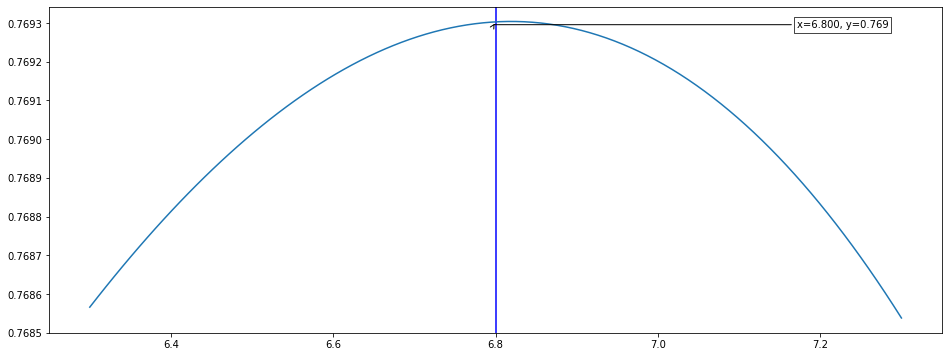

In [ ]:
PL2=[]
RL2=[]
LL2=[]
ML2=[]
SHARES2=[]
VM2=[]
cotacao2=[]
TK2=[]
TKE2=[]

for tkr2 in dff0['Papel']:
  urlf = 'http://fundamentus.com.br/detalhes.php?papel={}'.format(tkr)
  header = {
    "User-Agent": "Chrome/50.0.2661.75",
    "X-Requested-With": "XMLHttpRequest"
  }
  rf = requests.get(urlf, headers=header)

  dff = pd.read_html(rf.text, decimal=',', thousands='.')

  dff1=dff[0]
  if dff1[3][0]=='0.00':
    cotacao.append("nan")
  else:
    cotacao.append(float(dff1[3][0]))
  dff2=dff[2]
  SHARES2.append(float(dff[1].iloc[1,3]))
  VM2.append(float(dff[1].iloc[0,1])) #VALOR DE MERCADO
  #EV=dff[1].iloc[1,1] #VALOR DA FIRMA
  #LL_fd=dff[4].iloc[4,1] #LUCRO LIQUIDO PELO SITE FUNDAMENTUS
  RL12=float(dff[4].iloc[2,1])
  RL2.append(RL12) #RECEITA LIQUIDA
  PL2.append(float(dff[3].iloc[-1,-1]))
  #EBIT_fd=(dff[4].iloc[3,1]) #EBIT PELO SITE FUNDAMENTUS
  LL12=float(dff[4].iloc[4,1]) #LUCRO LIQUIDO PELO SITE FUNDAMENTUS
  LL2.append(LL12)
  if RL12==0 or abs(LL12/RL12)<0.00001:
    ML2.append(float(0))
  else:
    ML2.append(float(LL12/RL12)) #Margem Líquida
  if len(tkr2)==5:
    TKE2.append(tkr2[:-1])
  else:
    TKE2.append('NaN') #Excluir Units
  TK2.append(tkr2)

RESULTADO2=pd.concat([pd.Series(TK2),pd.Series(PL2),pd.Series(RL2),pd.Series(LL2),pd.Series(ML2),pd.Series(SHARES2),pd.Series(VM2),pd.Series(cotacao2),pd.Series(TKE2)],axis=1, sort=False,ignore_index=True)
RESULTADO2.columns=['tkr','PL','RL','LL','ML','Nº Acoes','Valor de Mercado','Cotacao','tkr_n']
RESULTADO2=RESULTADO2[~(RESULTADO2['tkr_n']=='NaN')] #Retirando units
RESULTADO2=RESULTADO2[~(RESULTADO2['ML']==0)] #Retirando ações com ML=0
RESULTADO2=RESULTADO2.drop_duplicates(subset=['tkr_n'], keep='first') #Retirando ações repetidas 

display(RESULTADO2)

VMl2=RESULTADO2.iloc[:,6]

def MaxCor2(u):
  pb2=[]
  for k in range(len(RESULTADO)):
    x=RESULTADO.iloc[k].values
    pb2.append((x[1] + x[2])+ (x[3])*(abs(x[4])**(-u*abs(x[4]))))
  R2=correlp(pb2, VMl2)
  return R2


maxc2=scipy.optimize.fmin(lambda x: -MaxCor2(x), 6.8)

print("O valor para máxima correlação encontrada foi de ",maxc2[0])

x2=np.linspace(maxc2[0]-0.5,maxc2[0]+0.5,100)

y2=[]
for k in x2:
  y2.append(MaxCor(k))

plt.figure(figsize=(16, 6))
def annot_max(x,y, ax=None):
    xmax = maxc2[0]
    ymax = MaxCor(maxc2[0])
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(x,y)
plt.axvline(x=maxc2[0],color='blue', 
            label="Ponto Máximo: {}".format(maxc2[0]))
plt.plot(x2,y2)
plt.show()